In [1]:
import sys
import json
import os
import requests
import random
from datetime import datetime
import time

import pandas as pd
import numpy as np
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib notebook


## Run a serving workload

In [2]:
def load_digits(digits_location, digits_filename = "train.data", norm=True):
    digits_path = digits_location + "/" + digits_filename
    print("Source file: %s" % digits_path)
    df = pd.read_csv(digits_path, sep=",", header=None)
    data = df.values
    print("Number of image files: %d" % len(data))
    y = data[:,0]
    X = data[:,1:]
    Z = X
    if norm:
        mu = np.mean(X,0)
        sigma = np.var(X,0)
        Z = (X - mu) / np.array([np.sqrt(z) if z > 0 else 1. for z in sigma])
    return Z, y

def filter_data(data):
    cx, cy = data
    binary_x = []
    binary_y = []
    for i in range(len(cy)):
        if cy[i] == 3:
            binary_x.append(cx[i,:])
            binary_y.append(1.0)
        elif cy[i] == 6:
            binary_x.append(cx[i,:])
            binary_y.append(0.0)
    return np.array(binary_x), np.array(binary_y)
            

def mnist_update(host, uid, x, y):
    url = "http://%s:1337/update" % host
    req_json = json.dumps({'uid': uid, 'input': list(x), 'label': y})
    headers = {'Content-type': 'application/json'}
    start = datetime.now()
    r = requests.post(url, headers=headers, data=req_json)
    end = datetime.now()
    latency = (end - start).total_seconds() * 1000.0
    print("'%s', %f ms" % (r.text, latency))

def mnist_prediction(host, uid, x):
    url = "http://%s:1337/predict" % host
    req_json = json.dumps({'uid': uid, 'input': list(x)})
    headers = {'Content-type': 'application/json'}
    # x_str = ", ".join(["%d" % a for a in x])
    start = datetime.now()
    r = requests.post(url, headers=headers, data=req_json)
    end = datetime.now()
    latency = (end - start).total_seconds() * 1000.0
    pred = float(r.text.split(":")[1].strip())
    return (pred, latency)



def send_updates(num_updates):
    uid = 0
    for i in range(num_updates):
        example_num = np.random.randint(0, len(test_y))
        mnist_update(host, uid, test_x[example_num], float(test_y[example_num]))

def run_iteration(uid):
    correct = 0
    false_pos = 0
    false_neg = 0
    latencies = []
    true_pos = 0
    true_neg = 0
    total = 100
    for i in range(total):
        example_num = np.random.randint(0, len(test_y))
        correct_y = float(test_y[example_num])
        pred_y, latency = mnist_prediction(host, uid, test_x[example_num])
        if correct_y == pred_y:
            if correct_y == 0:
                true_neg += 1
            elif correct_y == 1:
                true_pos += 1
            correct += 1
        elif correct_y == 0 and pred_y == 1:
            false_pos += 1
        elif correct_y == 1 and pred_y == 0:
            false_neg += 1
        else:
            print "predicted: {p}, correct: {c}".format(p=pred_y, c=correct_y)
        latencies.append(latency)
    total = float(total)    
    return (float(correct)/total,
            float(false_pos)/total,
            float(false_neg)/total,
            float(true_pos)/total,
            float(true_neg)/total,
            np.mean(latencies))

def run_serving_workload():
    fig, (ax_acc, ax_lat) = plt.subplots(2,1, sharex=True)
    ax_acc.set_ylabel("accuracy")
    ax_lat.set_xlabel("iterations")
    ax_lat.set_ylabel("latency")
    ax_acc.set_ylim(0, 1.0)
    xs = []
    accs = []
    lats = []
    j = 0
    uid = 0
    while True:
        correct, fp, fn, tp, tn, mean_lat, = run_iteration(uid)
        xs.append(j)
        accs.append(correct)
        lats.append(mean_lat)
        j += 1
        ax_acc.set_xlim(0, j + 1)
        ax_lat.set_xlim(0, j + 1)
        
        ax_acc.plot(xs, accs, 'b')
        ax_lat.plot(xs, lats, 'r')
        ax_lat.set_ylim(0, 150)
        fig.canvas.draw()
        print "Accuracy: {cor}, false positives: {fp}, false negatives: {fn}, true positives: {tp}, true negatives: {tn}".format(
            cor=correct, fp=fp, fn=fn, tp=tp, tn=tn)
        print "Mean latency: {lat} ms".format(lat = mean_lat)
        
            
    


In [4]:
test_x, test_y = filter_data(load_digits(os.path.expanduser("~/model-serving/data/mnist_data"), digits_filename="test.data"))
host = "ec2-52-53-148-130.us-west-1.compute.amazonaws.com"

Source file: /Users/crankshaw/model-serving/data/mnist_data/test.data
Number of image files: 10000


<IPython.core.display.Javascript object>


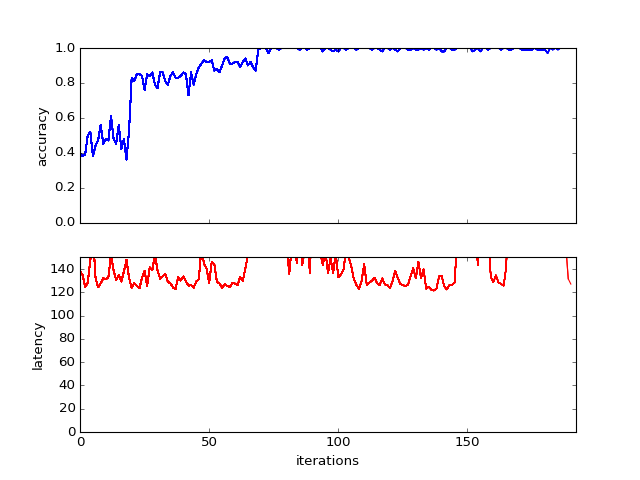

Accuracy: 0.4, false positives: 0.0, false negatives: 0.6, true positives: 0.0, true negatives: 0.4
Mean latency: 138.17029 ms
Accuracy: 0.38, false positives: 0.0, false negatives: 0.62, true positives: 0.0, true negatives: 0.38
Mean latency: 134.9582 ms
Accuracy: 0.39, false positives: 0.0, false negatives: 0.61, true positives: 0.0, true negatives: 0.39
Mean latency: 124.69532 ms
Accuracy: 0.5, false positives: 0.0, false negatives: 0.5, true positives: 0.0, true negatives: 0.5
Mean latency: 128.20788 ms
Accuracy: 0.52, false positives: 0.0, false negatives: 0.48, true positives: 0.0, true negatives: 0.52
Mean latency: 147.70589 ms
Accuracy: 0.38, false positives: 0.0, false negatives: 0.62, true positives: 0.0, true negatives: 0.38
Mean latency: 169.88839 ms
Accuracy: 0.44, false positives: 0.0, false negatives: 0.56, true positives: 0.0, true negatives: 0.44
Mean latency: 132.80971 ms
Accuracy: 0.47, false positives: 0.0, false negatives: 0.53, true positives: 0.0, true negatives:

ConnectionError: ('Connection aborted.', BadStatusLine("''",))

In [5]:
# send_updates(200)
run_serving_workload()